In [30]:
import cv2
import os
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
from pathlib import Path
import random
import plotly.express as px
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from PIL import Image
from sklearn.svm import SVC



In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

: 

: 

In [2]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

2023-11-29 22:32:47.048693: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 22:32:47.108394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 22:32:47.108438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 22:32:47.109952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 22:32:47.120388: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
## deprecated

# import torch                                # PyTorch for deep learning
# import torch.nn as nn                       # PyTorch's neural network module
# import torch.optim as optim                 # PyTorch's optimization module
# import torchvision                          # PyTorch's computer vision module
# import torchvision.datasets as datasets     # PyTorch's datasets module
# import torchvision.transforms as transforms # PyTorch's transforms module for data preprocessing
# from torch.autograd import Variable         # PyTorch's Variable for automatic differentiation
# import torch.utils.data as data             # PyTorch's data handling module
# from torch.utils.data import DataLoader     # PyTorch's DataLoader for creating data loaders
# import torch.nn.functional as F            # PyTorch's functional module for activation functions

In [4]:
#Set seed
random.seed(1126)

### _Data Exploration/Preprocessing_

First lets create a function to load in the dataset. 
- Data should be in the 'imagedata' folder within the repository. Dataset was collected from:
- The following block of code defines a function intended to load the collection of image files into 3 seperate arrays, a multidimentional matrix 'X' defining the actual pixel representation of data, an array 'y' returning a numerical label for each corresponding image in X, and a dictionary 'labels' which defines which emotions the numbers are intended to represent.
- The labels for each image are coming from the actual folders in which the images are located (Sorted by emotion)

In [2]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    #Loading images folder by folder
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            #Setting image label to the name of folder image is in
            labels[i] = path
            for file in os.listdir(dir_path +'/'+ path):
                if not file.startswith('.'):
                    #loading in each individual image
                    img = cv2.imread(dir_path + '/'+ path + '/' + file)
                    img
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    #Converting lists to np arrays
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

Now to declare directories:

In [3]:
#Setting Directories (Training/Testing folders are nested for some reason lol)
TRAIN_DIR = ('imagedata/Training/Training')
TEST_DIR = ('imagedata/Testing/Testing')

#creating output folder for pickles
OUTPUT_DIR = Path('output')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#defining pickle files
reducedtrainfile = (OUTPUT_DIR / 'reducetrain.pickle')
reducedtestfile = (OUTPUT_DIR / 'reducetest.pickle')

Loading in the data:

In [4]:
IMG_SIZE= (48, 48)
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


28273 images loaded from imagedata/Training/Training directory.


100%|██████████| 7/7 [00:01<00:00,  6.54it/s]

7067 images loaded from imagedata/Testing/Testing directory.


In [7]:
#checking out train test split
len(X_train)/(len(X_train) +len(X_test))

0.8000282965478211

In [8]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

We can see from the output of load_data that we have 28273 images in our training dataset, and 7067 in our testing dataset which is about an 80% train/test spilt. We have 6 emotional categories, as seen above. Looking at the class distribution:

In [9]:
graphlabelstrain, graphcountstrain = np.unique(y_train, return_counts=True)
graphlabelstest, graphcountstest = np.unique(y_test, return_counts=True)

For the training set:

In [10]:
fig1 = px.bar(x = graphlabelstrain, y = graphcountstrain, labels = train_labels)
fig1.update_layout(xaxis_title="Emotion")
fig1.update_xaxes(tickvals = list(train_labels.keys()), ticktext=list(train_labels.values()))
fig1.show()

And for the testing set:

In [11]:
fig2 = px.bar(x = graphlabelstest, y = graphcountstest, labels = train_labels)
fig2.update_layout(xaxis_title="Emotion")
fig2.update_xaxes(tickvals = list(train_labels.keys()), ticktext=list(train_labels.values()))
fig2.show()

We can see a similar distribution for both the training and testing datasets. 'Happy' seems to be slightly overreperesented in both datasets, so this is potentially something to look out for, but the rest of the distributions seem relatively even.

Now lets look at a sample image:

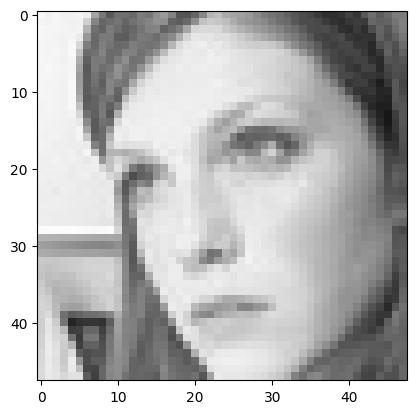

In [12]:
plt.imshow(X_train[0])

Ok! We have what appears to be a 48x48 image of a man scowling, which we would assume to be classified as an 'Angry" face. Lets create a function to test labels to make sure everything is lined up.

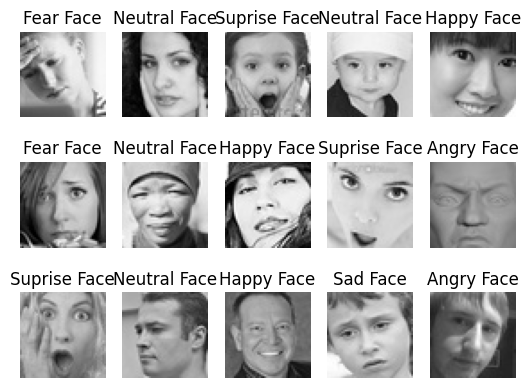

In [13]:
#function that takes in a dataset of images, their labels, a dictionary of their lables
# and a tuple containing a desired grid of image samples
def check_labels(dataset, y_labels, labels, sample_size = (3,5)):
    samples = np.random.randint(0, len(dataset), size=sample_size)
    fig, ax = plt.subplots(len(samples),len(samples[0]))
    for i in range(len(samples)):
        for j in range(len(samples[0])):
            ax[i,j].imshow(dataset[samples[i,j]])
            ax[i,j].set_title(f'{labels[y_labels[samples[i,j]]]} Face')
            ax[i,j].axis('off')
            
            

check_labels(X_train, y_train, train_labels)

It appears that the labels are matched up. Now lets take a closer look at the actual image data:

In [14]:
X_train.shape

(28273, 48, 48, 3)

We can see that our data is broken into a 4 dimentional matrix
- We can see from earlier that the first layer storing each individual image.

Thinking about what might be contained in the second, third, and fourth layers, given we are working with image data one might hypothesise:
- second layer represents each row of the picture
- third layer representing each pixel withing that row (Or the column value of the pixel)
- 4th layer a len 3 vector representing the pixel value of each pixel

Lets play with the data to find out! Going back to our sample image:

array([0.972549, 0.972549, 0.972549], dtype=float32)

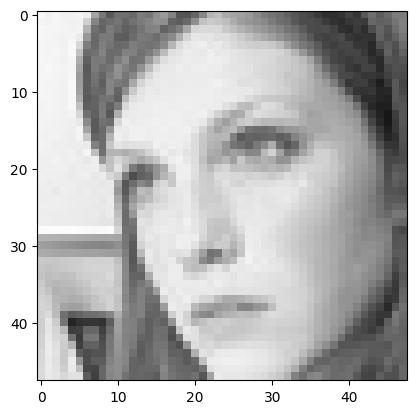

In [15]:
plt.imshow(X_train[0])
X_train[0,0,0]

We can see that pixel (0,0) (a pure white square) returns an array of [1,1,1]. This suggests that RGB values are from 0-1 instead of 0-255. We can test this hypothesis, and test how the data is structured (x vs y) at the same time:

In [16]:
originalx_train0519 = X_train[0,5,19]
originalx_train028 = X_train[0,2,8]
print(f"Pixel 1 (5,19) RGB value:{originalx_train0519}")
print(f"Pixel 2 (2,8) RGB value:{originalx_train028}")

Pixel 1 (5,19) RGB value:[0.9254902 0.9254902 0.9254902]
Pixel 2 (2,8) RGB value:[0.3882353 0.3882353 0.3882353]


To make sure we are tracking pixels correctly, lets make pixel 1 red, and pixel 2 green.

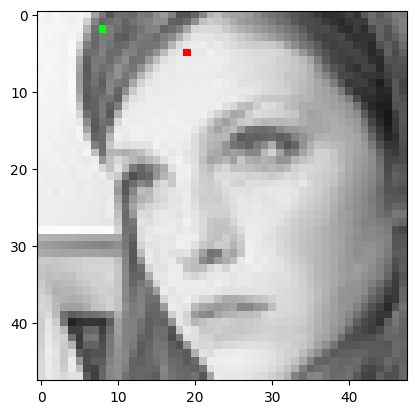

In [17]:
X_train[0,5,19] = [1,0,0]
X_train[0,2,8] = [0,1,0]
plt.imshow(X_train[0])

Nice! This little experiment let us know three things:
- The RGB values are indeed from 0-1 instead of 0-255, with 0 being black and 1 being white
- The second layer of our dataset map to X values of the image, and the third layer of our dataset maps to the y values.
- Since our images are in grayscale, the RGB values are going to be the same for each pixel

Now lets return our picture to its original state:

In [18]:
#Returning pixels to original values:
X_train[0,5,19] = [0.8627451, 0.8627451, 0.8627451]
X_train[0,2,8] = [0.99215686, 0.99215686, 0.99215686]


This last point is interesting, and gives us a nice starting point for attempting some dimentionality reduction. Since the RGB values for each pixel are the same (images are grayscale), a natural first step would be to reduce the RGB values from an array of 3 values to a single float.

### _Dimentionalty Reduction_

Our next phase of this project is trying to reduce the dimentionality of our dataset, so that our models have an easier time sorting through and making classifications. As mentioned previously, a good starting point would be to reduce the obvious redundancy of our original data. Lets create a function to do just that.

In [6]:
#function to reduce dimentionality of data 
#function first checks for pickled data stored in "file", and if found returns that information
#if not, function runs as normal and saves dataset as "file"
def reduce_array(dataset, file, rerun=False):
        if file.is_file() and rerun==False:
            with open(file, "rb") as f:
                reduceddata = pickle.load(f)
        else:
            reduceddata = np.zeros((len(dataset),len(dataset[0]),len(dataset[0,0])))
            for i in tqdm(range(len(dataset))):
                for j in range(len(dataset[i])):
                    for k in range(len(dataset[i,j])):
                        #converting each array to a single float of the mean value of each value in the array
                        reduceddata[i,j,k] = dataset[i,j,k].mean()
            with open(file, "wb") as f:
                pickle.dump(reduceddata, f)
        return reduceddata

Now to reduce the training and test datasets:

In [26]:
reducedtrainfile.is_file()

False

In [9]:
reduced_train = reduce_array(X_train, reducedtrainfile)
reduced_test = reduce_array(X_test, reducedtestfile)

Now lets try to reduce the dimentionality of this dataset even further. Lets first use PCA as a means of dimentionality reduction. Below is a function for applying pca to our reduced training and testing datasets, with a desired ratio of retained information:

In [35]:
def apply_pca(dataset, ratio=.95, sample=True):
    #reshape image data into 2d array for pca imput
    shape = (len(dataset[0])*len(dataset[0,0]))
    pcaprep = np.reshape(dataset, (len(dataset),shape))
    #apply pca (default 95% of variance)
    pca = PCA(ratio)
    pca.fit(pcaprep)
    transform = pca.transform(pcaprep)
    if sample == True:
        fig, ax = plt.subplots(1,2)
        inverse = pca.inverse_transform(transform)
        ax[0].imshow(dataset[10], cmap = 'gray')
        ax[0].set_title("Original")
        ax[1].imshow(inverse[10].reshape(48,48), cmap='gray')
        ax[1].set_title("Transformed")
        
    return pca, transform

We can use this function we made to return us a reduced matrix (transform), and to visualize the degree to which an image has been transformed.

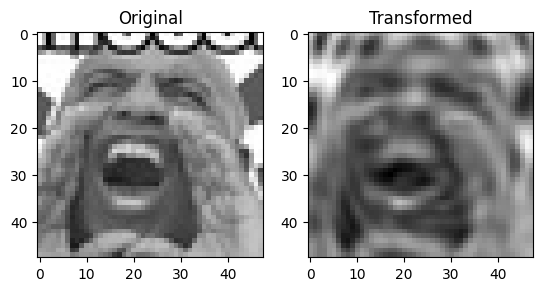

In [11]:
pca_train, transform_train = apply_pca(reduced_train)

To better visualize the component to explained variance ratio, lets graph the full components to explained variance PCA, and draw a line at the .95% mark:

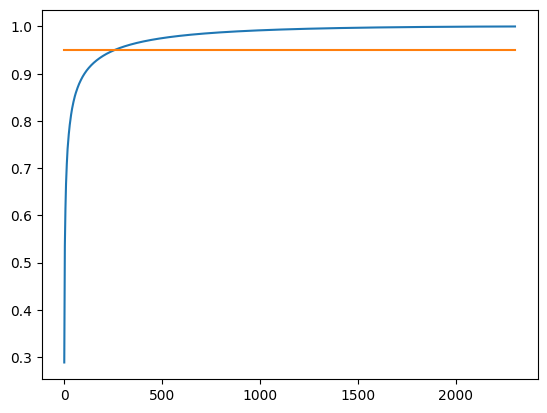

In [267]:
def visualize_pca(dataset, ratio=.95):
    shape = (len(dataset[0])*len(dataset[0,0]))
    pcaprep = np.reshape(dataset, (len(dataset),shape))
    #running pca without components to capture all component data
    pca = PCA()
    pca.fit(pcaprep)
    #plotting components vs cumulative explained ratio
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    #making ratio line
    x = np.linspace(0, (len(dataset[0])*len(dataset[0,0])), 100)
    y = ratio * np.ones_like(x)
    plt.plot(x, y, label=f'y = {ratio}')
visualize_pca(reduced_train)

From this graph, it seems like .95 is a great ratio for our components (around 200ish), since it hits right at the elbow before the steep decrease in explained variance growth! So I say for now we keep our ratio as is and apply pca to the test dataset as well.

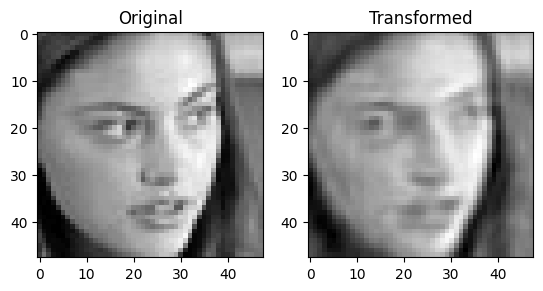

In [12]:
pca_test, transform_test = apply_pca(reduced_test, ratio=258)

In [288]:

transform_train.shape

(28273, 258)

Looking at the shape of our transformed matrix, we can see that we're down to only 258 dimentions. From the 6912 dimentions we started with (48x48x3), thats almost a 96% reduction in dimentionality!

Just for fun, lets try to visualize a PCA in 3 dimentions to see if there's any obvious trends we can find.

In [274]:
pca3 = PCA(n_components=3)
pcaprep = np.reshape(reduced_train, (len(reduced_train),(len(reduced_train[0])*len(reduced_train[0,0]))))
pca3D = pca3.fit_transform(pcaprep)
fig = px.scatter_3d(x=pca3D[:,0], y=pca3D[:,1], z=pca3D[:,2], color=y_train)
fig.show()

Doesn't really look like we can visualize anything useful in 3 dimentions, but it was worth a shot :)

Now lets continue with a little LDA:

In [13]:
lda = LinearDiscriminantAnalysis()
ldaprep = reduced_train.reshape(28273, 48*48)

ldareduced = lda.fit_transform(reduced_train.reshape(28273, 48*48), model_train_labels)

In [12]:


ldareducedtest = lda.fit_transform(reduced_test.reshape(7067, 48*48), model_test_labels)

## TESTING

In [ ]:
ldaformodel = lda.fit(reduced_train.reshape(28273, 48*48), model_train_labels)
with open(OUTPUT_DIR / 'trainedlda.pickle', "wb") as f:
    pickle.dump(ldaformodel, f)

In [31]:
uploaded_image = Image.open('/Users/edmond/github/Sad-Smile/imagedata/Training/Training/Suprise/Suprise-999.jpg')
uploaded_image = np.array(uploaded_image)
uploaded_image = uploaded_image.astype('float32') / 255
img = cv2.resize(uploaded_image, IMG_SIZE, interpolation = cv2.INTER_AREA)

In [33]:
img.shape

(48, 48)

In [22]:
reduced_train.reshape(28273, 48*48).shape

(28273, 2304)

In [40]:
img_lda = ldaformodel.transform(img.reshape(1, 48*48))

In [54]:
model = SGD_LDAdata1
predictions = model.predict_proba(img_lda)
predictions.reshape(6)

array([0.22637745, 0.38553987, 0.08402232, 0.06577377, 0.14096207,
       0.09732452])

In [52]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [59]:
fig = px.bar(y=list(train_labels.values()), x=predictions.reshape(6), orientation='h')
fig.show()


### Lets also try Scaling the Data:

In [77]:
scaler = StandardScaler()
scaledtrain = scaler.fit_transform(reduced_train.reshape(28273, 48*48))
scaledtest = scaler.fit_transform(reduced_test.reshape(7067, 48*48))

and performing lda on that:

In [78]:
ldascaled = lda.fit_transform(scaledtrain, model_train_labels)
ldascaledtest = lda.fit_transform(scaledtest, model_test_labels)

(28273, 2304)

### THE REST IS A WORK IN PROGRESS:

Lets try some classification models:

In [11]:
model_train_labels = [train_labels[i] for i in y_train]
model_test_labels = [test_labels[i] for i in y_test]


In [14]:
model_train_labels

['Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',
 'Angry',


In [306]:
NB_model = GaussianNB()
NB_model.fit(reduced_train.reshape(28273, 48*48), model_train_labels)
NB_model.score(reduced_test.reshape(7067, 48*48), model_test_labels)

0.24833734257818027

Yikes! Thats rather low for a baseline model. Lets maybe try redoing the PCA to see if adding dimentions helps.

(28273, 588)

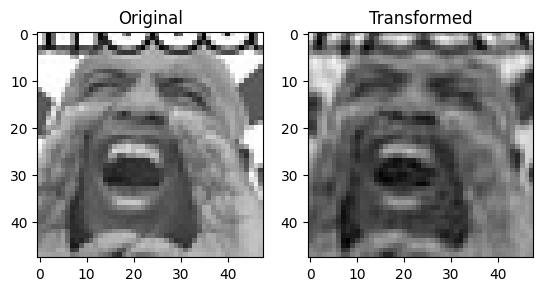

In [36]:
pca_train, transform_train = apply_pca(reduced_train, ratio=.98)
transform_train.shape

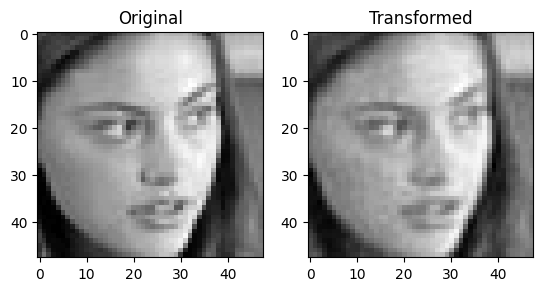

In [37]:
pca_test, transform_test = apply_pca(reduced_test, ratio=588)

In [305]:
transform_test.shape

(7067, 588)

In [302]:
NB_model = GaussianNB()
NB_model.fit(transform_train, model_train_labels)
NB_model.score(transform_test, model_test_labels)

0.1962643271543795

### MLP:

In [1]:
MLPmodel = MLPClassifier()

NameError: name 'MLPClassifier' is not defined

Original Dataset:

Reduced dataset:

In [310]:
MLPmodel = MLPClassifier()
MLPmodel.fit(reduced_train.reshape(28273, 48*48), model_train_labels)
    
  


GaussianNB()

In [311]:
MLPmodel.score(reduced_test.reshape(7067, 48*48), model_test_labels)

0.3905476156785057

PCA:

In [312]:
MLPmodel.fit(transform_train, model_train_labels)
MLPmodel.score(transform_test, model_test_labels)

0.17348238290646667

LDA:

## Linear classifiers (SVM, logistic regression, etc.) with SGD training.

In [15]:
SGDmodel = SGDClassifier()

Original Data

In [27]:
#5m 14.2s
SGD_originaldata = SGDmodel.fit(X_train.reshape(28273, 48*48*3), model_train_labels)
SGD_originaldata.score(X_test.reshape(7067, 48*48*3), model_test_labels)


0.2681477288807132

Reduced Data:

In [32]:
#1m 29.5s
SGD_reduceddata = SGDmodel.fit(reduced_train.reshape(28273, 48*48), model_train_labels)
SGD_reduceddata.score(reduced_test.reshape(7067, 48*48), model_test_labels)

0.30309891042875337

PCA:

In [42]:
#0m 16.2s
SGD_PCAdata = SGDmodel.fit(transform_train, model_train_labels)
SGD_PCAdata.score(transform_test, model_test_labels)

0.1896136974671006

LDA:

In [50]:
#0m 0.2s
SGD_LDAdata = SGDmodel.fit(ldareduced, model_train_labels)
SGD_LDAdata.score(ldareducedtest, model_test_labels)

0.5685580868826942

Wowzers! By far the best results we've had so far, and the quickest! Lets try it with some more models eh?

In [14]:
SGDmodel1 = SGDClassifier(loss='log_loss')
SGD_LDAdata1 = SGDmodel1.fit(ldareduced, model_train_labels)
SGD_LDAdata1.score(ldareducedtest, model_test_labels)

0.6729871232489033

In [64]:
SGDmodel2 = SGDClassifier(loss='modified_huber')
SGD_LDAdata1 = SGDmodel2.fit(ldareduced, model_train_labels)
SGD_LDAdata1.score(ldareducedtest, model_test_labels)

0.6240271685297863

In [73]:
SGDmodel3 = SGDClassifier(loss='square_hinge')
SGD_LDAdata1 = SGDmodel2.fit(ldareduced, model_train_labels)
SGD_LDAdata1.score(ldareducedtest, model_test_labels)


0.6168105278052922

Scaled data:

In [81]:
#1m 48.8s
SGD_scaleddata = SGDmodel.fit(scaledtrain, model_train_labels)
SGD_scaleddata.score(scaledtest, model_test_labels)

0.2914956841658412

Scaled LDA:

In [87]:
SGD_ldascaled = SGDmodel.fit(ldascaled,model_train_labels)
SGD_ldascaled.score(ldascaledtest, model_test_labels)

0.5309183529078817

In [15]:
SGDmodel1 = SGDClassifier(loss='log_loss')
SGD_LDAdata1 = SGDmodel1.fit(ldascaled, model_train_labels)
SGD_LDAdata1.score(ldascaledtest, model_test_labels)

NameError: name 'ldascaled' is not defined

In [108]:
SGDmodel3 = SGDClassifier(loss='modified_huber')
SGD_LDAdata2 = SGDmodel3.fit(ldascaled, model_train_labels)
SGD_LDAdata2.score(ldascaledtest, model_test_labels)

0.5746427055327579

Save models:

In [16]:
with open(OUTPUT_DIR / 'SGDmodel_original.pickle', "wb") as f:
    pickle.dump(SGD_originaldata, f)

with open(OUTPUT_DIR / 'SGDmodel_reduceddata.pickle', "wb") as f:
    pickle.dump(SGD_reduceddata, f)

with open(OUTPUT_DIR / 'SGDmodel_PCAdata.pickle', "wb") as f:
    pickle.dump(SGD_reduceddata, f)

with open(OUTPUT_DIR / 'SGDmodel_LDAdata.pickle', "wb") as f:
    pickle.dump(SGD_LDAdata1, f)

with open(OUTPUT_DIR / 'SGDmodel_scaleddata.pickle', "wb") as f:
    pickle.dump(SGD_scaleddata, f)


NameError: name 'SGD_originaldata' is not defined

In [17]:
with open(OUTPUT_DIR / 'SGDmodel_LDAdata.pickle', "wb") as f:
    pickle.dump(SGD_LDAdata1, f)

## C-Support Vector Classification

In [100]:
SVCmodel = SVC(C= .1, verbose=True)

In [101]:
SVCmodel.fit(ldareduced, model_train_labels)
SVCmodel.score(ldareducedtest, model_test_labels)

[LibSVM]...*
optimization finished, #iter = 3170
obj = -477.040777, rho = 0.041200
nSV = 5004, nBSV = 4912
...
*.*
optimization finished, #iter = 4078
obj = -568.554354, rho = 0.181594
nSV = 5933, nBSV = 5832
...
*
optimization finished, #iter = 3468
obj = -504.704980, rho = -0.048140
nSV = 5281, nBSV = 5177
...
*
optimization finished, #iter = 3651
obj = -527.482313, rho = 0.030828
nSV = 5518, nBSV = 5420
.
*.*
optimization finished, #iter = 2026
obj = -287.901182, rho = -0.253361
nSV = 3103, nBSV = 3010
...
*
optimization finished, #iter = 3990
obj = -560.324127, rho = 0.090057
nSV = 5857, nBSV = 5749
...
*
optimization finished, #iter = 3545
obj = -517.438229, rho = -0.087142
nSV = 5407, nBSV = 5320
...
*
optimization finished, #iter = 3582
obj = -528.639151, rho = 0.011789
nSV = 5513, nBSV = 5426
..
*
optimization finished, #iter = 2555
obj = -349.811560, rho = -0.332874
nSV = 3711, nBSV = 3614
...
*.*
optimization finished, #iter = 4182
obj = -626.199454, rho = -0.299687
nSV = 650

0.6690250459883967

In [103]:
MLPmodel = MLPClassifier()
MLPlda = MLPmodel.fit(ldareduced, model_train_labels)
MLPlda.score(ldareducedtest, model_test_labels)

0.6686005377104853

## CNN with Pytorch

In [8]:
with open(OUTPUT_DIR / 'VGG19m3model.pickle', "rb") as f:
    model = pickle.load(f)

2023-11-29 22:34:20.589833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4055 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2023-11-29 22:34:20.590985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30952 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0
2023-11-29 22:34:20.591642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 30952 MB memory:  -> device: 2, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:88:00.0, compute capability: 7.0
2023-11-29 22:34:20.592616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 30952 MB memory:  -> device: 3, name: Tesla V100S-PCIE-32GB, pci bus

In [9]:
model

In [10]:
predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

#confusion_mtx = confusion_matrix(y_test, y_pred) 
#cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

2023-11-29 22:34:51.507999: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-11-29 22:34:55.051254: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:110] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Running ptxas --version returned 32512
2023-11-29 22:34:55.357558: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-29 22:34:56.000792: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:504] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cud

221/221 [==============================] - 12s 14ms/step
Test Accuracy = 0.58


In [ ]:
#CNN
#image segmentation
#svd - faster but still slow lower accuracy
#KMEANS
#SVM
#RF
